log 𝑁 = 𝑎 − 𝑏𝑀

1. Magnitude-frequency relation – Gutenberg-Richter Law
2. Compute b-value (relation between magnitude and number of earthquakes) using linear regression


Source of the earthquake data used in this code:
[USGS] https://earthquake.usgs.gov/earthquakes/search/

Parameters used to download the data: \
Location: 39.5 - 41.5 degrees North and 120 - 130 degrees West \
Magnitude: minimum = 2.0 
File format 'csv'



## 1. Earthquake distribution

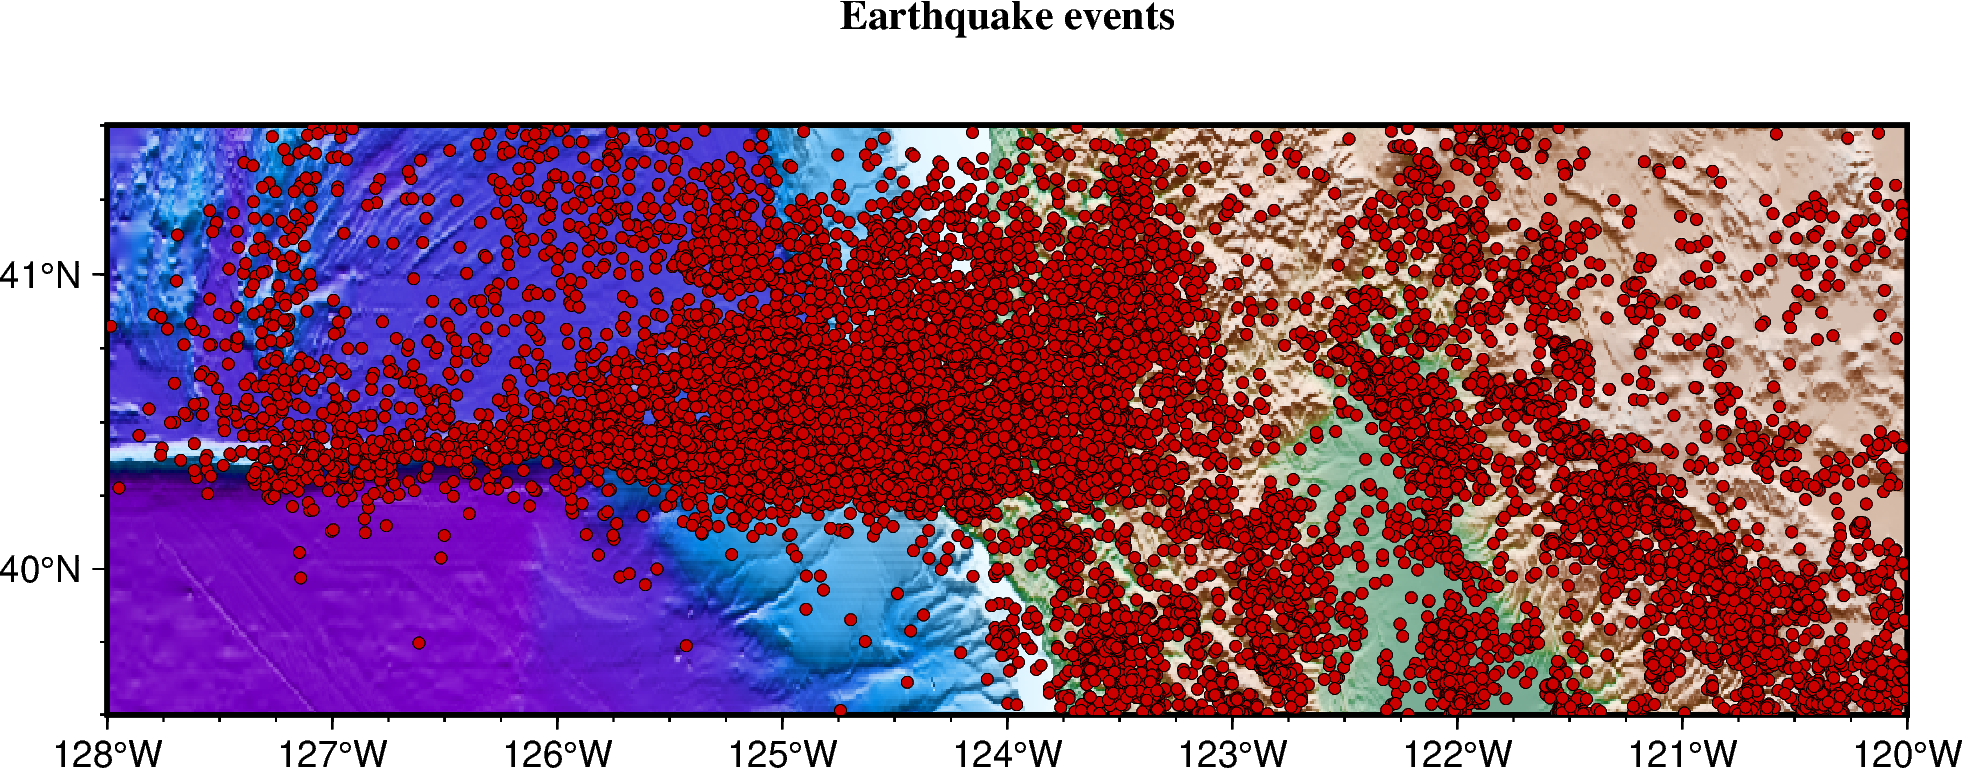

In [1]:
""" 
Purpose of this code is to -
- Plot earthquake events using `pygmt` package
- plot magnitude vs frequency 
- calculate correlatin between magnitude and frequency by linear regression

"""

# import all necessary packages
import pandas as pd
import matplotlib.pyplot as plt
import pygmt
import numpy as np
import os

# create a image directory if it does not exist
if not os.path.exists('png'):
    os.mkdir('png')

# read in the earthquake catalog file
df = pd.read_csv('../HW_3/all_query-1970_20230901_2-10.csv', header=0, parse_dates=[0, 12])

# Plot the events on map using pygmt
# Define area by geographic coordinates
region = [-128, -120, 39.5, 41.5]

# Import/download relief data with 30s resolution
grid = pygmt.datasets.load_earth_relief(region=region, resolution='30s')

# Apply shade to the grid
shade = pygmt.grdgradient(grid=grid, azimuth=90/270, normalize='t1')

# Make color palette table
pygmt.makecpt(cmap='terra', series=[-7000, 7000])

# Create a figure instance in pygmt
fig = pygmt.Figure()

# Define figure configuration (auto can be selected for most of these options)
pygmt.config(FONT_TITLE='10p,5', MAP_TITLE_OFFSET='auto', MAP_FRAME_TYPE='plain')

# Plot the downloaded grid with color-coding based on the elevation
## projection=M-125/40/6i, cmap='terra' or 'geo', cmap=True uses previously created 
## colormap in `makecpt`.

fig.basemap(region=region, projection="M6i", frame=['f', "+tEarthquake events"])
fig.grdimage(
    grid=grid,
    shading=shade,
    projection='M6i',
    frame=['a1f0.5'],
    cmap='terra'
)

# Plot the events on map
#define lat, lon
x, y = df['longitude'].values, df['latitude'].values
fig.plot(
    x=x,
    y=y,
    #style=circular|0.1|centimeter/in/point
    style='c0.1c',
    #line around the point-shape. pen=1|point/cm/in
    pen='0.1p',
    #filcolor
    fill='red3'
)


# Save the figure in a png file
fig.savefig('png/events_map.png', dpi=300)

# Show figure
fig.show(dpi=300, width='6000')

# 3. Plotting earthquake counts vs magnitude:
This Gutenberg-Richter relation describes that there should be 10 times more earthquakes for the 1 lower magnitude, 100 times more earthquakes for 2 lower magnitudes. If there are 50 magnitude-8 earthquakes in a region there should be 500 magnitude-7 earthquakes in the same area within same timeframe.
\
This is described by this relation:
$$log 𝑁 = 𝑎 − 𝑏𝑀$$
where b should be 1.0 ideally.
N, M are the two consecutive magnitudes
`a` is a constant

/Users/mdarifulislam/miniconda3/envs/obspy/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


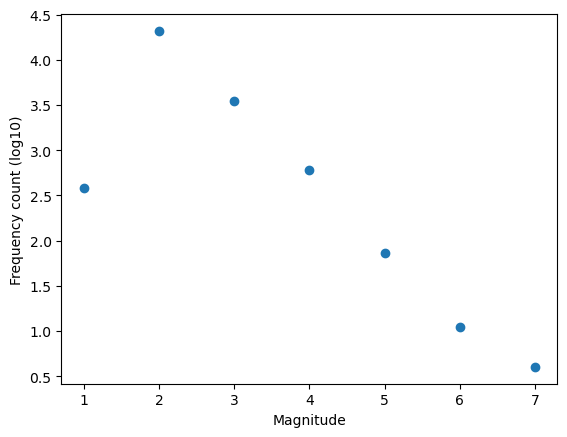

In [2]:
''' this is a non-cumulative plot of magnitude vs frequency '''
# Create bins for magnitude ranges
mag_bins = np.arange(1,11,1)

# Use pd.cut to create bins and then count the occurrences in each bin
mag_counts = pd.cut(df['mag'], bins=mag_bins).value_counts().sort_index()
mag_counts_log = np.log10(mag_counts)
mag_counts_df = pd.DataFrame(mag_counts).reset_index(drop=True)
mag_counts_df.columns = ['counts']

counts = mag_counts_df['counts']
counts_log = np.log10(counts)

# change the mag_bins 
mags = np.arange(1,10,1)

# Plot the magnitude vs frequency
fig, ax = plt.subplots()

ax.scatter(mags, counts_log)
# ax.set_yscale('log')
ax.set_xlabel('Magnitude')
ax.set_ylabel('Frequency count (log10)')

plt.show()

In [3]:
""" Define a linear and relu function. """

def linear(x : np.ndarray, w : float = 1, b : float = 0) -> np.ndarray:
    """ returns w*x + b """
    return w*x + b


def relu(x : np.ndarray) -> np.ndarray:
    """ returns x if x is positive, 0 otherwise"""
    return np.maximum(x, 0) # np.maximum returns the element-wise maximum of two arrays


""" Define a function that is the sum of two relus. """
def relu_sum(x : np.ndarray, w : np.ndarray, b : np.ndarray, bias : float = 0) -> np.ndarray:
    """ returns relu(w[0]*x + b[0]) + relu(w[1]*x + b[1]) + bias """
    return relu(w[0]*x + b[0]) + relu(w[1]*x + b[1]) + bias


""" Define a loss function. """
def loss(y_true : np.ndarray, y_pred : np.ndarray) -> float:
    """ returns the mean squared error between y_true and y_pred """
    loss = (1/len(y_true))*np.sum((y_true - y_pred)**2)
    return loss

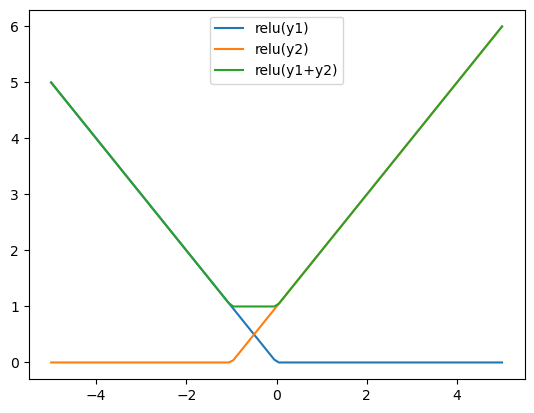

In [4]:
""" Test the relu function. """
import matplotlib.pyplot as plt

x = np.linspace(-5, 5, 100)

y1 = relu(linear(x, w=-1, b=0))
y2 = relu(linear(x, w=1, b=1))

plt.plot(x, y1, label="relu(y1)")
plt.plot(x, y2, label="relu(y2)")
plt.plot(x, y1+y2, label="relu(y1+y2)")
plt.legend()

# Fitting the earthquake frequency vs magnitude function with reLUs using PyTorch

In [5]:
""" Define a neural network with a single hidden layer. """
# import pytorch
import torch
import torch.nn as nn
# set the random seed for reproducibility
torch.manual_seed(5984)

""" Show the initial model prediction/fit (it's bad)"""

class Net(nn.Module):
    def __init__(self, n_relus : int = 2):

        super().__init__()

        # create a neural net
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, n_relus), # layer 1
            nn.ReLU(), # layer 2
            nn.Linear(n_relus, 1), # layer 3
        )


    def forward(self, x):

        # similar to evaluate func
        out = self.linear_relu_stack(x)
        return out

# Training the model using the simple way

In [6]:
# convert the x values and y values to pytorch tensors
xt = torch.from_numpy(mags).unsqueeze(1).to(torch.float32)
yt = torch.from_numpy(counts.values).unsqueeze(1).to(torch.float32)

# create the 2 relu model
model_2 = Net(n_relus = 2)

# calculate the prdiction
pred = model_2(xt)

In [7]:
# set hyperparameters
learning_rate = 0.01
training_steps = 1000

# define the model
torch.manual_seed(5984)
model_2 = Net(n_relus = 50000)

# define the loss function
loss_fn = nn.MSELoss()

# define the optimizer
optim = torch.optim.Adam(model_2.parameters(), lr = learning_rate)

for n in range(training_steps):
    # calculate the prediction
    pred = model_2(xt)

    # calculate the loss
    loss = loss_fn(pred, yt)

    # zero the gradients
    optim.zero_grad()

    # calculate the gradients of the parameters wrt the loss
    loss.backward()

    # update the parameters
    optim.step()

    # print the loss every 100 steps
    if n % 100 == 0:
        print(f"Step {n}: {loss.item():.3f}")

Step 0: 49694112.000
Step 100: 26699744.000
Step 200: 21973576.000
Step 300: 16087161.000
Step 400: 10376276.000
Step 500: 5988370.000
Step 600: 2859000.250
Step 700: 1108793.375
Step 800: 372685.188
Step 900: 108033.461


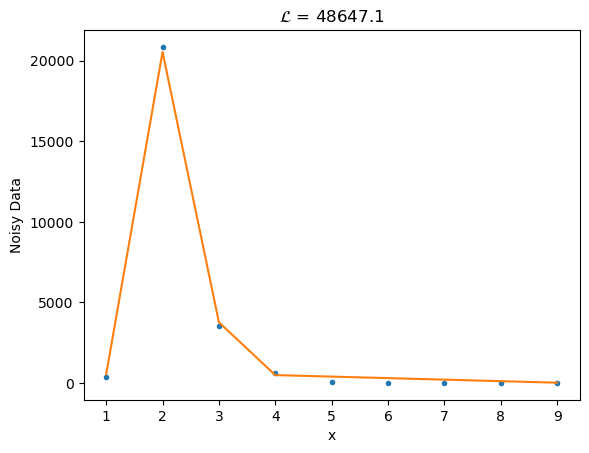

In [8]:
""" Plot the trained model. """
# calcuate the prediction
pred = model_2(xt)

# calculate the loss
loss = loss_fn(pred, yt)

# plot the noisy data and fit
fig, ax = plt.subplots()

ax.plot(mags, counts, '.', label="data")
ax.plot(mags, pred.detach().numpy(), label="fit")
ax.set_xlabel("x")
ax.set_ylabel("Noisy Data")
ax.set_title("$\mathcal{L}$ = " +  f"{loss.item():.1f}")
plt.show()

# Increase the number of relus to 50000